Manga Faces Mood Classifier

Dataset: https://www.kaggle.com/datasets/mertkkl/manga-facial-expressions

References: 

1.   [ \[Pytorch\] - Manga Facial Expression Classificationt](https://www.kaggle.com/code/mertkkl/pytorch-manga-facial-expression-classification/)
2.   [POZZ (MAIS Hacks submission)](https://github.com/amnbot/POZZ/blob/master/jupyter/model.ipynb)


**To look at:**

https://stackoverflow.com/questions/61858768/why-is-the-accuracy-of-my-pretrained-resnet-152-model-so-low


In [1]:
# Imports

import torchvision
import torchvision.datasets as datasets # For importing dataset
import torchvision.models as models # For ResNet-50

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import numpy as np


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Device to send data and model to

In [3]:
from PIL import Image, ImageEnhance
# transform class to make images sharper
class Sharpie(object):
    def __init__(self,factor):
        self.factor = factor

    def __call__(self, x):
        enhancer = ImageEnhance.Sharpness(x)
        img = enhancer.enhance(self.factor)
        return img

**From PyTorch [documentation](https://pytorch.org/hub/pytorch_vision_resnet/):**

"All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]."

In [4]:
# Image preprocessing
from torchvision import transforms

factor = 2

# Original images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = factor),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

# Horizontally flipped images
preprocess2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.RandomHorizontalFlip(1),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = factor),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

# Rotated 45 to 90
preprocess3 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.RandomRotation([45, 75]),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = factor),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

# Rotated -90 to -45
preprocess4 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.RandomRotation([-75,-45]),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = factor),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

# Rotated 45 to 90 + flipped
preprocess5 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomRotation([45, 75]),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = factor),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

# Rotated -90 to -45 + flipped
preprocess6 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomRotation([-75,-45]),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = factor),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

In [5]:
# Load the dataset
dataset_ori = datasets.ImageFolder('manga-faces', transform=preprocess)
dataset_hf = datasets.ImageFolder('manga-faces', transform=preprocess2)
dataset_pr = datasets.ImageFolder('manga-faces', transform=preprocess3)
dataset_nr = datasets.ImageFolder('manga-faces', transform=preprocess4)
dataset_hf_pr = datasets.ImageFolder('manga-faces', transform=preprocess5)
dataset_hf_nr = datasets.ImageFolder('manga-faces', transform=preprocess6)
dataset = torch.utils.data.ConcatDataset([dataset_ori, dataset_hf, dataset_pr, dataset_nr, dataset_hf_pr, dataset_hf_nr])
print(len(dataset))
dataset_size = len(dataset)

4080


In [6]:
# Split the dataset into training and testing dataset
# Using a 80 % of data for training and 20 % for training
train_size = int(0.9 * dataset_size)
num_display_images = 5
test_size = dataset_size - train_size - num_display_images
train_ds, test_ds, display_imgs = data.random_split(dataset, [train_size, test_size, num_display_images])

In [7]:
train_loader = data.DataLoader(train_ds, shuffle=True, batch_size=15)
test_loader = data.DataLoader(test_ds, shuffle=True, batch_size=10)
display_loader = data.DataLoader(display_imgs, shuffle=True, batch_size=num_display_images)

[Visualizing a grid of images](https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py)

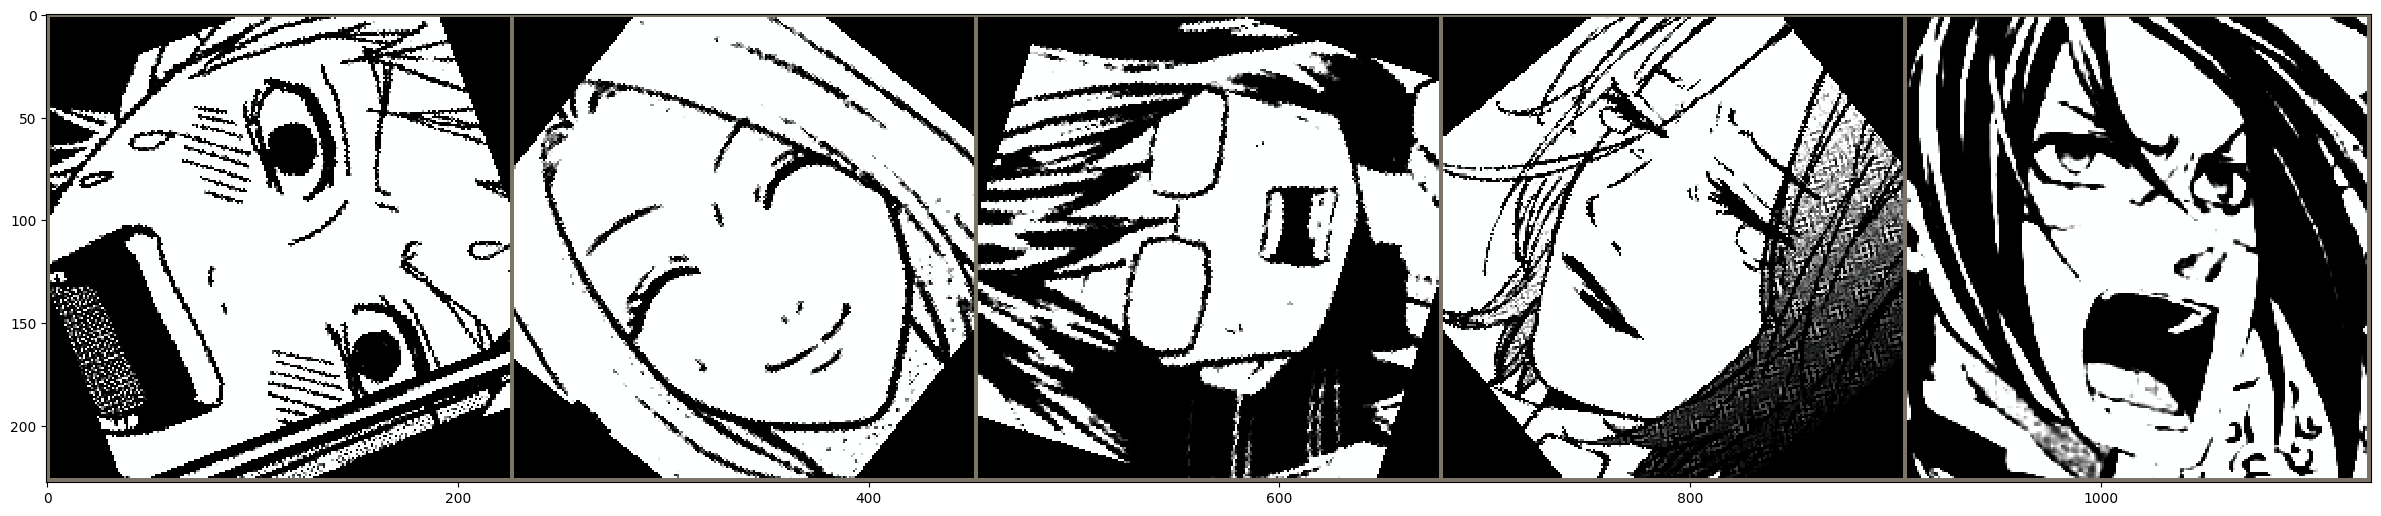

In [8]:
# Display the images (for preprocessing)
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Func

def show(imgs):
  ax = plt.subplots(figsize = (30, 90))
  inp = imgs.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp, interpolation='nearest')

inputs, labels = next(iter(display_loader))
# idx_to_class = {v: k for k, v in display_loader.dataset.dataset.class_to_idx.items()}
# display_moods = []
# for label in labels:
#   display_moods.append(idx_to_class[int(label)])
# print(display_moods)
grid = make_grid(inputs)
show(grid)

**From PyTorch [documentation](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)**

"By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients. This will make more sense later."

In [9]:
criter = nn.CrossEntropyLoss()
model = models.resnet50(pretrained=True)

# Replace the last fully-connected (fc) layer since we only have 7 classes
for param in model.parameters():
    param.requires_grad  = False

in_feats = model.fc.in_features
num_classes = 7
model.fc = nn.Linear(in_feats, num_classes)
model = model.to(device) # Move model to device

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [10]:
# Training function (training done twice, once for the last layer, and another time for the entire model)

def train_model(model, epoch, loss_lst):
  model.train()
  running_loss = 0

  for batch, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device) # Move data to device
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criter(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*inputs.size(0)

    if (batch % 20 == 0):
      print(f'Epoch: {epoch} \t Loss: {loss}')
  
  running_loss /= len(train_loader.dataset)
  loss_lst.append(running_loss)
  print(f'Average loss: {running_loss}')

In [11]:
# Train last layer

num_epochs_last_layer = 50
print('Training last layer...')
train_loss = []
for epoch in range(1, num_epochs_last_layer + 1):
  train_model(model, epoch, train_loss)

Training last layer...
Epoch: 1 	 Loss: 2.01088809967041
Epoch: 1 	 Loss: 1.786940097808838
Epoch: 1 	 Loss: 1.8892322778701782
Epoch: 1 	 Loss: 1.9368817806243896
Epoch: 1 	 Loss: 1.4239370822906494
Epoch: 1 	 Loss: 1.778327465057373
Epoch: 1 	 Loss: 2.028771162033081
Epoch: 1 	 Loss: 1.474324107170105
Epoch: 1 	 Loss: 1.4733949899673462
Epoch: 1 	 Loss: 1.4320495128631592
Epoch: 1 	 Loss: 1.6108161211013794
Epoch: 1 	 Loss: 1.612799882888794
Epoch: 1 	 Loss: 1.5885502099990845
Average loss: 1.7405872158949671
Epoch: 2 	 Loss: 1.5933464765548706
Epoch: 2 	 Loss: 1.1832553148269653
Epoch: 2 	 Loss: 1.2864651679992676
Epoch: 2 	 Loss: 1.3396164178848267
Epoch: 2 	 Loss: 1.5747586488723755
Epoch: 2 	 Loss: 1.8319836854934692
Epoch: 2 	 Loss: 1.452178955078125
Epoch: 2 	 Loss: 1.2567527294158936
Epoch: 2 	 Loss: 1.829784870147705
Epoch: 2 	 Loss: 1.9238338470458984
Epoch: 2 	 Loss: 1.481917142868042
Epoch: 2 	 Loss: 1.6097437143325806
Epoch: 2 	 Loss: 1.5481338500976562
Average loss: 1.45

[1.7405872158949671, 1.4511397145932017, 1.372050783116054, 1.26406413857259, 1.2445738852218864, 1.2170788138812663, 1.1928666573431757, 1.1730029065332381, 1.1601707758564574, 1.1326906114962756, 1.112135280775868, 1.1204721418763297, 1.11398848421336, 1.095186546688376, 1.0579998606901153, 1.0623568541863386, 1.0517694320456654, 1.0343213490167864, 1.0370540293116195, 1.0243753098876647, 1.0528516976613236, 1.0070652418520325, 1.0150047142082959, 1.0310717887105116, 1.0157405943944564, 0.9840800058267085, 0.9539187094987998, 0.9743956922754353, 0.990414018091423, 0.9890959285004856, 0.9795237046976885, 0.9877723883472237, 0.9683400753617676, 0.9582384211175582, 0.9450118335487406, 0.9540064784826017, 0.9704616373173551, 1.0118813422916373, 0.9395128423287198, 0.9548042410485496, 0.916450636936169, 0.9069095251022601, 0.898559758914452, 0.9071967183472285, 0.9020956124550377, 0.9060684217298343, 0.866413316232901, 0.9012886769095667, 0.9174710821019474, 0.8836705594329662]


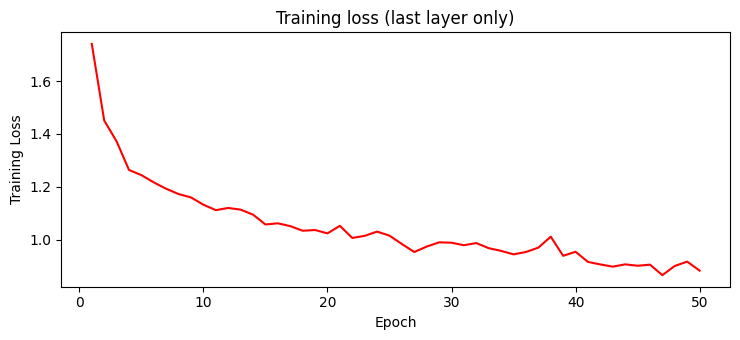

In [12]:
print(train_loss)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training loss (last layer only)")
plt.plot(range(1, len(train_loss) + 1), train_loss, color="red")
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.show()

From [docs](https://pytorch.org/docs/stable/generated/torch.argmax.html):



```
>>> a = torch.randn(4, 4)
>>> a
tensor([[ 1.3398,  0.2663, -0.2686,  0.2450],
        [-0.7401, -0.8805, -0.3402, -1.1936],
        [ 0.4907, -1.3948, -1.0691, -0.3132],
        [-1.6092,  0.5419, -0.2993,  0.3195]])
>>> torch.argmax(a, dim=1)
tensor([ 0,  2,  0,  1])
```



In [13]:
# Testing function

def test_model(model, loader, accuracy):
  total = 0
  correct = 0
  preds = []
  targets = []

  model.eval()
  with torch.no_grad():
    
    for batch, (inputs, labels) in enumerate(loader):
      inputs, labels = inputs.to(device), labels.to(device) # Move data to device

      outputs = model(inputs)
      # Use dim=1 to keep an array of the indices of the max values for each output
      pred = outputs.argmax(dim = 1, keepdim = False)
      for p in pred:
        preds.append(int(p))
      for l in labels:
        targets.append(int(l))
      res = torch.eq(pred, labels)
      for r in res:
        total += 1
        if r == True:
          correct += 1
      accuracy.append(correct / total)
      if (batch % 5 == 0):
        print(f'Accuracy: {correct} / {total} ({round((correct / total), 2)} %)')
    return torch.as_tensor(preds), torch.as_tensor(targets)

In [14]:
from torchmetrics import ConfusionMatrix
# Training accuracy for last layer
training_accuracy = []
preds, targets = test_model(model, train_loader, training_accuracy)
confmat = ConfusionMatrix(num_classes=7)
confmat(preds, targets)

Accuracy: 14 / 15 (0.93 %)
Accuracy: 75 / 90 (0.83 %)
Accuracy: 130 / 165 (0.79 %)
Accuracy: 191 / 240 (0.8 %)
Accuracy: 243 / 315 (0.77 %)
Accuracy: 301 / 390 (0.77 %)
Accuracy: 357 / 465 (0.77 %)
Accuracy: 415 / 540 (0.77 %)
Accuracy: 470 / 615 (0.76 %)
Accuracy: 530 / 690 (0.77 %)
Accuracy: 585 / 765 (0.76 %)
Accuracy: 640 / 840 (0.76 %)
Accuracy: 692 / 915 (0.76 %)
Accuracy: 751 / 990 (0.76 %)
Accuracy: 803 / 1065 (0.75 %)
Accuracy: 858 / 1140 (0.75 %)
Accuracy: 912 / 1215 (0.75 %)
Accuracy: 962 / 1290 (0.75 %)
Accuracy: 1019 / 1365 (0.75 %)
Accuracy: 1071 / 1440 (0.74 %)
Accuracy: 1123 / 1515 (0.74 %)
Accuracy: 1177 / 1590 (0.74 %)
Accuracy: 1238 / 1665 (0.74 %)
Accuracy: 1292 / 1740 (0.74 %)
Accuracy: 1344 / 1815 (0.74 %)
Accuracy: 1408 / 1890 (0.74 %)
Accuracy: 1464 / 1965 (0.75 %)
Accuracy: 1518 / 2040 (0.74 %)
Accuracy: 1574 / 2115 (0.74 %)
Accuracy: 1628 / 2190 (0.74 %)
Accuracy: 1682 / 2265 (0.74 %)
Accuracy: 1733 / 2340 (0.74 %)
Accuracy: 1787 / 2415 (0.74 %)
Accuracy: 1836

tensor([[283,   6,  19,  28,   3,  56,  60],
        [ 16, 244,  39,  23,   0,  80,  43],
        [  9,   7, 344,  31,   1,  43,  46],
        [  4,   5,  22, 625,  11,  64,  42],
        [  7,   3,  15,  58, 228,  83,  35],
        [  2,   1,   4,  11,   2, 412,  11],
        [  6,   4,  13,  20,   3,  23, 577]])

In [15]:
from torchmetrics.functional import precision_recall
precision_recall(preds, targets, average='micro', num_classes=7)

(tensor(0.7388), tensor(0.7388))

In [16]:
# Testing accuracy for last layer
testing_accuracy = []
preds, targets = test_model(model, test_loader, testing_accuracy)
confmat = ConfusionMatrix(num_classes=7)
confmat(preds, targets)

Accuracy: 6 / 10 (0.6 %)
Accuracy: 44 / 60 (0.73 %)
Accuracy: 78 / 110 (0.71 %)
Accuracy: 109 / 160 (0.68 %)
Accuracy: 140 / 210 (0.67 %)
Accuracy: 166 / 260 (0.64 %)
Accuracy: 198 / 310 (0.64 %)
Accuracy: 229 / 360 (0.64 %)
Accuracy: 256 / 403 (0.64 %)


tensor([[25,  2,  4,  6,  0,  9, 13],
        [ 2, 21,  3,  3,  0, 10,  7],
        [ 2,  2, 44,  4,  0,  7, 12],
        [ 5,  1,  1, 59,  2,  7,  4],
        [ 1,  0,  1,  3, 23, 14,  8],
        [ 1,  0,  0,  2,  0, 37,  3],
        [ 2,  0,  2,  1,  0,  3, 47]])

In [17]:
precision_recall(preds, targets, average='micro', num_classes=7)

(tensor(0.6352), tensor(0.6352))

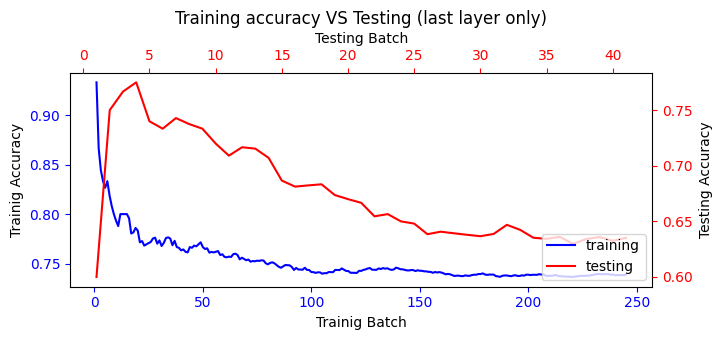

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, label="training")
ax2 = fig.add_subplot(111, label="testing", frame_on=False)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training accuracy VS Testing (last layer only)")

ax.plot(range(1, len(training_accuracy) + 1), training_accuracy, color="blue", label="training")
ax.set_xlabel("Trainig Batch")
ax.set_ylabel("Trainig Accuracy")
ax.tick_params(axis='x', colors="blue")
ax.tick_params(axis='y', colors="blue")

ax2.plot(range(1, len(testing_accuracy) + 1), testing_accuracy, color="red", label="testing")
ax2.set_xlabel("Testing Batch")
ax2.set_ylabel("Testing Accuracy")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="red")
ax2.tick_params(axis='y', colors="red")

handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc="lower right")
plt.show()

In [19]:
# Set requires_grad = True for the layer
for param in model.parameters():
  param.requires_grad = True

# Train entire model
num_epochs_entire_model = 50
model_train_loss = []
print('Training entire model...')
for epoch in range(1, num_epochs_entire_model + 1):
  train_model(model, epoch, model_train_loss)

Training entire model...
Epoch: 1 	 Loss: 1.2848896980285645
Epoch: 1 	 Loss: 2.1326985359191895
Epoch: 1 	 Loss: 2.034482717514038
Epoch: 1 	 Loss: 1.6919134855270386
Epoch: 1 	 Loss: 1.9303499460220337
Epoch: 1 	 Loss: 1.67247474193573
Epoch: 1 	 Loss: 1.830283284187317
Epoch: 1 	 Loss: 2.1235928535461426
Epoch: 1 	 Loss: 1.8101128339767456
Epoch: 1 	 Loss: 1.274045467376709
Epoch: 1 	 Loss: 1.4403728246688843
Epoch: 1 	 Loss: 1.4922256469726562
Epoch: 1 	 Loss: 1.4410853385925293
Average loss: 1.88157885511911
Epoch: 2 	 Loss: 1.4619535207748413
Epoch: 2 	 Loss: 1.2405966520309448
Epoch: 2 	 Loss: 1.68431556224823
Epoch: 2 	 Loss: 1.5913574695587158
Epoch: 2 	 Loss: 1.1595698595046997
Epoch: 2 	 Loss: 1.7125930786132812
Epoch: 2 	 Loss: 1.5861659049987793
Epoch: 2 	 Loss: 1.1088610887527466
Epoch: 2 	 Loss: 0.6662829518318176
Epoch: 2 	 Loss: 0.9667854309082031
Epoch: 2 	 Loss: 0.9187269806861877
Epoch: 2 	 Loss: 1.0998910665512085
Epoch: 2 	 Loss: 1.7667230367660522
Average loss: 1

[1.88157885511911, 1.3761494551219193, 1.1024836516555618, 0.999867382903699, 0.9195647600526903, 0.8596693294646304, 0.9106565762092086, 0.8088543865269695, 0.8005708955910081, 0.8166831963105139, 0.7965000323780806, 0.7353786233252559, 0.7432881274497977, 0.7341487800178964, 0.7038416238927764, 0.6659953191973804, 0.6511058960767353, 0.640734737093737, 0.6048385177684181, 0.5671228722797013, 0.4802113244450024, 0.5110966532119836, 0.4806779144952695, 0.4778715136272261, 0.4094069358204899, 0.4382003509360396, 0.42079692182368506, 0.39085493188692266, 0.38384790503072974, 0.3582360673455363, 0.32169371521331713, 0.34177117952711733, 0.33238609954166937, 0.2889041408814271, 0.32103770940406307, 0.28597547063981393, 0.27899154860623715, 0.29138371060614543, 0.2825159660930094, 0.25007918039702026, 0.26738347722753103, 0.255181386191824, 0.22333773452517716, 0.2582308284092232, 0.2108024769231336, 0.26174199080179916, 0.22566908833896437, 0.23055589751468278, 0.21271969790850442, 0.19623

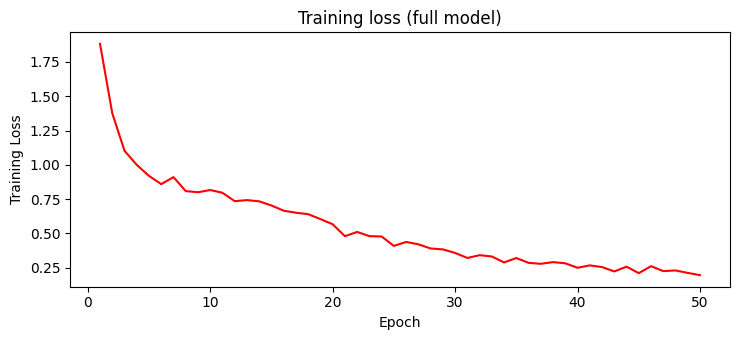

In [20]:
print(model_train_loss)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training loss (full model)")
plt.plot(range(1, len(model_train_loss) + 1), model_train_loss, color="red")
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.show()

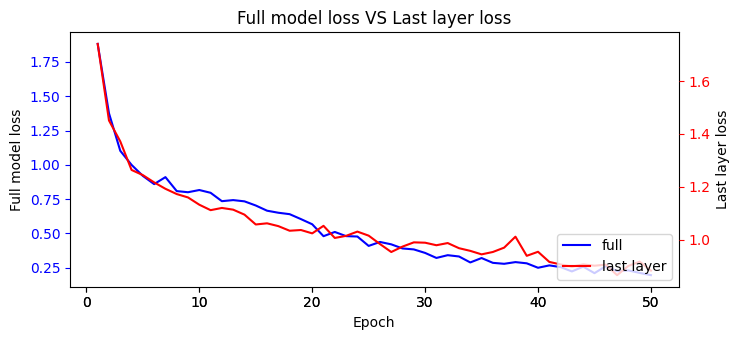

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, label="training")
ax2 = fig.add_subplot(111, label="testing", frame_on=False)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Full model loss VS Last layer loss")


ax.plot(range(1, len(model_train_loss) + 1), model_train_loss, color="blue", label="full")
ax.set_ylabel("Full model loss")
ax.tick_params(axis='y', colors="blue")

ax2.plot(range(1, len(train_loss) + 1), train_loss, color="red", label="last layer")
ax2.set_ylabel("Last layer loss")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', colors="red")

plt.xlabel('Epoch')
handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc="lower right")
plt.show()

In [22]:
# Training accuracy for entire model
model_training_accuracy = []
preds, targets = test_model(model, train_loader, model_training_accuracy)
confmat = ConfusionMatrix(num_classes=7)
confmat(preds, targets)

Accuracy: 15 / 15 (1.0 %)
Accuracy: 84 / 90 (0.93 %)
Accuracy: 152 / 165 (0.92 %)
Accuracy: 221 / 240 (0.92 %)
Accuracy: 292 / 315 (0.93 %)
Accuracy: 361 / 390 (0.93 %)
Accuracy: 433 / 465 (0.93 %)
Accuracy: 505 / 540 (0.94 %)
Accuracy: 577 / 615 (0.94 %)
Accuracy: 650 / 690 (0.94 %)
Accuracy: 720 / 765 (0.94 %)
Accuracy: 794 / 840 (0.95 %)
Accuracy: 867 / 915 (0.95 %)
Accuracy: 942 / 990 (0.95 %)
Accuracy: 1014 / 1065 (0.95 %)
Accuracy: 1087 / 1140 (0.95 %)
Accuracy: 1156 / 1215 (0.95 %)
Accuracy: 1225 / 1290 (0.95 %)
Accuracy: 1296 / 1365 (0.95 %)
Accuracy: 1368 / 1440 (0.95 %)
Accuracy: 1442 / 1515 (0.95 %)
Accuracy: 1512 / 1590 (0.95 %)
Accuracy: 1582 / 1665 (0.95 %)
Accuracy: 1652 / 1740 (0.95 %)
Accuracy: 1725 / 1815 (0.95 %)
Accuracy: 1796 / 1890 (0.95 %)
Accuracy: 1866 / 1965 (0.95 %)
Accuracy: 1937 / 2040 (0.95 %)
Accuracy: 2004 / 2115 (0.95 %)
Accuracy: 2075 / 2190 (0.95 %)
Accuracy: 2147 / 2265 (0.95 %)
Accuracy: 2217 / 2340 (0.95 %)
Accuracy: 2290 / 2415 (0.95 %)
Accuracy: 

tensor([[439,   0,   2,   5,   3,   0,   6],
        [ 20, 386,  12,   4,  10,   3,  10],
        [ 10,   1, 450,   2,  10,   0,   8],
        [  0,   0,   1, 734,  37,   0,   1],
        [  0,   0,   0,   0, 429,   0,   0],
        [ 10,   0,  11,   1,  15, 406,   0],
        [  6,   0,   1,   0,   2,   0, 637]])

In [23]:
precision_recall(preds, targets, average='micro', num_classes=7)

(tensor(0.9480), tensor(0.9480))

In [24]:
# Testing accuracy for entire model
model_testing_accuracy = []
preds, targets = test_model(model, test_loader, model_testing_accuracy)
confmat = ConfusionMatrix(num_classes=7)
confmat(preds, targets)

Accuracy: 9 / 10 (0.9 %)
Accuracy: 53 / 60 (0.88 %)
Accuracy: 94 / 110 (0.85 %)
Accuracy: 139 / 160 (0.87 %)
Accuracy: 183 / 210 (0.87 %)
Accuracy: 225 / 260 (0.87 %)
Accuracy: 267 / 310 (0.86 %)
Accuracy: 312 / 360 (0.87 %)
Accuracy: 348 / 403 (0.86 %)


tensor([[54,  0,  1,  2,  0,  0,  2],
        [ 2, 26,  6,  2,  1,  2,  7],
        [ 3,  1, 58,  0,  2,  1,  6],
        [ 0,  0,  0, 75,  4,  0,  0],
        [ 0,  0,  0,  0, 50,  0,  0],
        [ 4,  0,  2,  1,  2, 33,  1],
        [ 0,  0,  1,  2,  0,  0, 52]])

In [25]:
precision_recall(preds, targets, average='micro', num_classes=7)

(tensor(0.8635), tensor(0.8635))

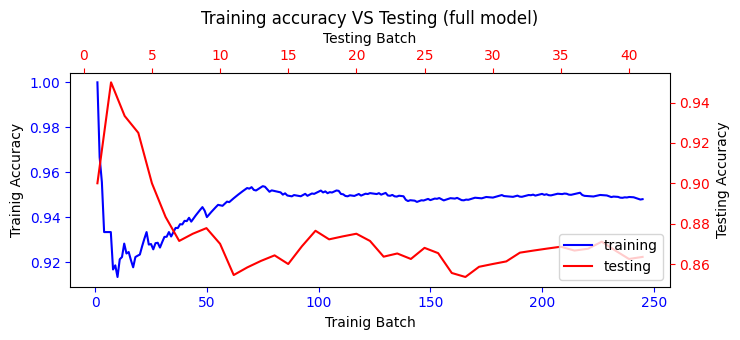

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, label="training")
ax2 = fig.add_subplot(111, label="testing", frame_on=False)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training accuracy VS Testing (full model)")

ax.plot(range(1, len(model_training_accuracy) + 1), model_training_accuracy, color="blue", label="training")
ax.set_xlabel("Trainig Batch")
ax.set_ylabel("Trainig Accuracy")
ax.tick_params(axis='x', colors="blue")
ax.tick_params(axis='y', colors="blue")

ax2.plot(range(1, len(model_testing_accuracy) + 1), model_testing_accuracy, color="red", label="testing")
ax2.set_xlabel("Testing Batch")
ax2.set_ylabel("Testing Accuracy")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="red")
ax2.tick_params(axis='y', colors="red")

handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc="lower right")
plt.show()

In [27]:
"""
Show a grid of the images, the prediction VS the expected answer
"""

'\nShow a grid of the images, the prediction VS the expected answer\n'

In [28]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted_2.pt') # Save